In [21]:
%matplotlib inline 
import math
import torch
import numpy as np
import time
from d2l import torch as d2l
import matplotlib as plt

#初始化两个向量
n = 10000
a = torch.ones([n])
b = torch.ones([n])

#定义一个计时器，对运行时间进行基准测试
class Timer:#@save
    def __init__(self):
        self.times = []
        self.start()#定义计时器时就开始计时

    def start(self):#启动计时
        self.tik = time.time()#time中的计时函数,记录当前的时间点

    def stop(self):
        self.times.append(time.time()-self.tik)
        return self.times[-1]#更新时间，并返回最近一次的时长

    def avg(self):
        return sum(self.times)/len(self.times)

    def sum(self):
        return sum(self.times)

    def cumsum(self):
        #返回累计时间，返回一个列表，元素为之前时间的总和
        return np.array(self.times).cumsum().tolist()#先把列表转为向量，算累计和，再将向量转为列表 

In [17]:
#标量运算
c = torch.zeros([n])
timer = Timer()
for i in range(n):
    c[i] = a[i]+b[i]
f'{timer.stop():.5f} sec'

'0.08822 sec'

In [18]:
#矢量化运算
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

# 定义函数计算正态分布并可视化

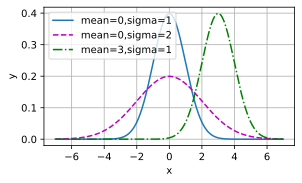

In [25]:

def normal(x,mu,sigma):
    p = 1/math.sqrt(2*math.pi*sigma**2)
    y = p*np.exp(-(x-mu)**2/(2*sigma**2))
    return y

x = np.arange(-7,7,0.01)#定义x向量，为-7到7的等差数列
params=[(0,1),(0,2),(3,1)]
d2l.plot(x,[normal(x,mu,sigma) for mu,sigma in params],xlabel='x',ylabel='y',figsize=(4.5,2.5),legend=[f'mean={mu},sigma={sigma}'for mu,sigma in params])
d2l.plt.show()

In [28]:
#根据线性模型生成数据集，包含两个特征,x由标准正态分布生成
def synthetic_data(w,b,num_examples):
    x = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(x,w)+b
    y += torch.normal(0,0.01,y.shape)
    return x,y.reshape((-1,1))


In [29]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)
print('feature:',features[0],'\n label:',labels[0])

feature: tensor([-1.2297, -0.0985]) 
 label: tensor([2.0752])


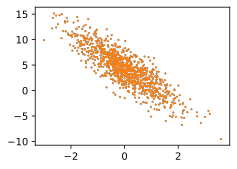

In [31]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1)#在索引时加括号是为了表明这是一个元组，在处理多维数组时，对一个维度的索引通常用元组表示
d2l.plt.show()#可以通过散点图观察出线性关系

In [35]:
import random
#定义函数，抽取小批量来更新模型，含有yield的函数又叫做生成器
def data_iter(batch_size,features,labels):
    num_example = len(features)
    indices = list(range(num_example))#创建0到num_examples-1的索引列表
    random.shuffle(indices)#将索引随机打乱，再按照batchsize进行抽取
    for i in range(0,num_example,batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_example)])
        yield features[batch_indices],labels[batch_indices]#用于逐批返回数值，相当于迭代器
        #结果本身为迭代器，一次引用一组数

In [39]:
batch_size = 10
#初始化模型参数
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

#定义模型
def linreg(X,w,b):
    return torch.matmul(X,w)+b
#定义损失函数,乘0.5能够让系数为1
def squared_loss(y_hat,y):
    #输入标量
    return (y_hat-y)**2 /2
#定义优化算法
def sgd(params,lr,batch_size):#训练集的信息在系数的梯度中保存
    with torch.no_grad():
        for param in params:
            param -= lr* param.grad /batch_size
            param.grad.zero_()#将梯度清除为0，

In [40]:
#训练过程
lr=0.03
num_epochs=3
net = linreg
loss = squared_loss#不是函数调用，将函数赋值给变量可以让后续的代码更简洁，如果要修改loss，只用在此处修改函数即可

In [41]:
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y)
        #因为l是一个向量，表示每个样本的损失，所以要求batch总损失，需要求和
        l.sum().backward()#梯度记录在损失函数的参数中，并没有更新
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        #每次迭代后，输出迭代次数和损失
        train_loss = loss(net(features,w,b),labels)
        print(f'epoch{epoch+1},loss{float(train_loss.mean()):f}')


epoch1,loss0.041571
epoch2,loss0.000160
epoch3,loss0.000048


In [42]:
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

w的估计误差：tensor([-0.0002, -0.0005], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0004], grad_fn=<RsubBackward1>)


# 使用深度学习框架来实现线性回归模型

In [1]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [2]:
def synthetic_data(w,b,num_examples):
    x = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(x,w)+b
    y += torch.normal(0,0.01,y.shape)
    return x,y.reshape((-1,1))
true_w = torch.tensor([2,-3.4])
true_b = 4.2

In [3]:
#初始化参数
true_weight  = torch.tensor([2,-3.4])
true_beta = 4.2
features,labels = synthetic_data(true_w,true_b,1000)

In [4]:
def load_array(data_arrays,batch_size,is_train=True):
    #构造数据迭代器
    dataset = data.TensorDataset(*data_arrays)#将列表元素解包，传递给函数
    return data.DataLoader(dataset,batch_size,shuffle=is_train)#创建一个数据加载器，是一个迭代器

In [5]:
batch_size = 10
data_iter = load_array((features,labels),batch_size)
#创建一个乱序的批次迭代器

In [6]:
#利用nn定义线性模型
from torch import nn
net = nn.Sequential(nn.Linear(2,1))#多层网络用sequential串联在一起，单层网络实际上不用该函数
#预定义方式初始化模型的参数
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)#net[0]访问第一个图层,bias.data访问第一层的参数，fill_重写参数值
loss = nn.MSELoss()#平方L2范数，默认返回平均值
#定义优化算法
trainer = torch.optim.SGD(net.parameters(),lr=0.03)#用net.parameters()从模型中获取参数，参数更新时用到batchsize,所以SGD实例指定了对应的公式，batchsize 从net的参数中获得。

In [7]:
#开始训练过程,一轮把所有的数据都过一遍，对损失函数自动求导，更新训练过程中的参数
num_epoch = 3
for epoch in range(num_epoch):
    for X,y in data_iter:
        l = loss(net(X),y)#net(X)获取预测值
        trainer.zero_grad()#梯度清零
        l.backward()
        trainer.step()
    l = loss(net(features),labels)
    print(f'epoch{epoch+1},loss{l:f}')


epoch1,loss0.000259
epoch2,loss0.000104
epoch3,loss0.000103


In [9]:
#获取网络参数
w = net[0].weight.data
print('w的估计误差为',true_weight-w.reshape(true_weight.shape))
b = net[0].bias.data
print('b的估计误差为',true_beta-b)

w的估计误差为 tensor([-0.0001, -0.0008])
b的估计误差为 tensor([5.6267e-05])
